In [1]:
#default_exp poi.train

In [2]:
from speechsep.imports import *
from speechsep.data import *
from speechsep.core import *
from speechsep.masks import *
from speechsep.utils import *
from speechsep.models import *

/home/cerberus/.anaconda3/envs/fastai/lib/python3.8/site-packages/fastcore/basics.py:790: UserWarning: `patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead
  warnings.warn("`patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead")


In [3]:
from speechsep.base import *

# From the start

In [4]:
def files2mask(files):
    tfms = [AudioMono.create, Resample(22050), Clip(5)]
    audios = [compose_tfms(f, tfms) for f in files]
    aud2mask = Maskify(MaskBinary)
    mixed_spec, masks = aud2mask(audios)
    return [mixed_spec, masks[0]]

In [5]:
class POIMesher:
    def __init__(self, poi):
        self.poi = poi

    def get_poi_files(self, path):
        return get_audio_files(path, folders=f"{self.poi}")

    def get_non_poi_files(self, path):
        files = get_audio_files(path)
        poi_path = path/str(self.poi)
        return [file for file in files if poi_path not in list(file.parents)]

    def __call__(self, path):
        rand_poi = []
        poi_files = self.get_poi_files(path)
        non_poi_files = self.get_non_poi_files(path)
        for x in range(len(non_poi_files)):
            rand_poi.append(random.choice(poi_files))
        return list(map(list,zip(rand_poi, non_poi_files)))

In [6]:
class SpecMaskDataset(torch.utils.data.Dataset):
    def __init__(self, files):
        self.files = files
        self.tensorify = ToTensor()
        self.trim = Unet_Trimmer(16)
        
    def __getitem__(self, i):
        spec, mask = files2mask(self.files[i])
        spec, mask = self.tensorify(spec), self.tensorify(mask)
        return self.trim(spec[:1]), self.trim(mask)
    
    def __len__(self): return len(self.files)

In [7]:
poi = "911"
fn = Path("/home/cerberus/Music/LibriSpeech/train-clean-100/")

files = POIMesher(poi)(fn)
train_ds = SpecMaskDataset(files[:-6000])
valid_ds = SpecMaskDataset(files[-6000:])

dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=2).cuda()

# Train

In [8]:
model = U_Net(img_ch=1, output_ch=1).cuda()

In [9]:
def custom_loss(inp, targ):
    targ = targ[:,None,:,:].permute(0,1,3,2)
    return BCEWithLogitsLossFlat()(inp, targ)*10

In [10]:
learn = Learner(dls, model, loss_func=custom_loss)

In [11]:
learn.validate()

(#1) [6.858211517333984]

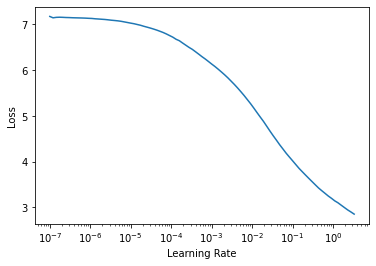

In [12]:
lr = learn.lr_find()

In [13]:
learn.fit_one_cycle(1, slice(*lr))

epoch,train_loss,valid_loss,time
0,0.317297,0.322884,1:08:37


In [14]:
learn.save("TrainBinary_1e_9")

Path('models/TrainBinary_1e_9.pth')

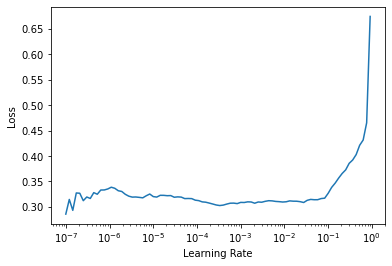

In [15]:
lr = learn.lr_find()

In [16]:
learn.fit_one_cycle(1, slice(*lr))

epoch,train_loss,valid_loss,time
0,0.307777,0.315451,1:08:30


In [17]:
learn.save("TrainBinary_2e_9")

Path('models/TrainBinary_2e_9.pth')